In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score, accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

# Data Cleaning and Featuring Engineering

In [28]:
# Reading in the raw data
h1 = pd.read_csv('data/H1.csv')
h2 = pd.read_csv('data/H2.csv')
raw_df = pd.concat([h1,h2], keys=['h1','h2'], names=['Hotel', 'drop']).reset_index().drop('drop', axis=1)
df = raw_df.copy()

#Dealing with missing values and dropping duplicates
df['Children'] = df['Children'].fillna(0)
df['Country'] = df['Country'].fillna('unknown')
df = df.drop_duplicates(keep='first').reset_index(drop=True)

#Replace negative ADR and unsually high ADR
ADR_neg_group = df.query('ReservationStatusDate == "2017-03-15" and StaysInWeekendNights == 4 and CustomerType == "Transient-Party" and ADR > 0')
df.loc[11591,'ADR'] = round(ADR_neg_group['ADR'].mean(),2)
ADR_high_group = df.query('ReservationStatusDate == "2016-02-19" and StaysInWeekNights == 1 and CustomerType == "Transient" and ADR < 5400 and Adults == 2')
df.loc[38749,'ADR'] = round(ADR_high_group['ADR'].mean(),2)

#Change to datetime
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])

#Drop rows with 0 people on the booking
df_zero_customers = df.query('Adults ==0 and Children ==0')
df.drop(df_zero_customers.index, axis=0, inplace=True)

#Drop rows with 0 nights on the booking
df_zero_nights = df.query('StaysInWeekendNights == 0 and StaysInWeekNights==0')
df.drop(df_zero_nights.index, axis=0, inplace=True)

#Drop rows with 0 ADR and are not complementary
df_zero_adr = df.query('ADR == 0 and MarketSegment != "Complementary"')
df.drop(df_zero_adr.index, axis=0, inplace=True)

#Create Continent and is_europe features
country_tables = pd.read_html('https://statisticstimes.com/geography/countries-by-continents.php')
countries = country_tables[2][['Country or Area', 'ISO-alpha3 Code', 'Region 1', 'Continent']]
country_continent = df['Country'].to_frame().merge(countries[['ISO-alpha3 Code','Continent']], how='left', left_on='Country', right_on='ISO-alpha3 Code')
df['Continent'] = country_continent['Continent']
df['Continent'] = df['Continent'].fillna('unknown')
df['is_europe'] = np.where(df['Continent'] == 'Europe', 1, 0)

# We will recode the months to their cooresponding integers
month_mapping = {'January':1,
                 'February':2,
                 'March':3,
                 'April':4,
                 'May':5,
                 'June':6,
                 'July':7,
                 'August':8,
                 'September':9,
                 'October':10,
                 'November':11,
                 'December':12}
df['ArrivalDateMonth'] = df['ArrivalDateMonth'].map(month_mapping)

# Create total_people feature
df['total_people'] = df['Children'] + df['Babies'] + df['Adults']

# Create total_nights and is_weekend features
df['total_nights'] = df['StaysInWeekNights'] + df['StaysInWeekendNights']
df['is_weekend'] = np.where(df['StaysInWeekendNights'] > 0, 1, 0)

# Clean and binarize meal feature
df['Meal'] = df['Meal'].replace('Undefined','SC       ').str.strip()
df['Meal'] = np.where(df['Meal'] == 'SC', 0, 1)

# Create cancellation_rate
df['cancellation_rate'] = (df['PreviousCancellations']/(df['PreviousCancellations']+df['PreviousBookingsNotCanceled'])).fillna(0)

# Create res_equals_assign
condition = df['ReservedRoomType'] == df['AssignedRoomType']
df['res_equals_assign'] = np.where(condition, 1, 0)

# Binarize BookingChanges
df['BookingChanges'] = np.where(df['BookingChanges'] > 0, 1, 0)

#Remove whitespace from strings
df['DepositType'] = df['DepositType'].str.strip()

# Create agent_type based on conditions
df['Agent'] = df['Agent'].str.strip()
df_agent = df['Agent'].to_frame()
df_agent_count = df.groupby('Agent')['Agent'].count().to_frame(name='counts')
df_agent_count = df_agent_count.reset_index()
df_agent_and_count = pd.merge(df_agent, df_agent_count, on = 'Agent', how='left')
conditions = [df_agent_and_count['Agent'] == "NULL",
              df_agent_and_count['counts'] <= 100,
              (df_agent_and_count['counts'] > 100)  & (df_agent_and_count['counts'] < 1000),
              df_agent_and_count['counts'] >= 1000]
options = ['no_agent', 'uncommon_agent','common_agent','popular_agent']
df_agent_and_count['agent_type'] = np.select(conditions, options)
df['agent_type'] = df_agent_and_count['agent_type']

# Binarize wait_list
df['wait_list'] = np.where(df['DaysInWaitingList'] > 0 ,1, 0)

# Create room_cost
df['room_cost'] = df['ADR']*df['total_nights']

# Binarize RequiredCarParkingSpaces
df['RequiredCarParkingSpaces'] = np.where(df['RequiredCarParkingSpaces'] > 0, 1, 0)

# Binarize TotalOfSpecialRequests
df['special_requests'] = np.where(df['TotalOfSpecialRequests'] > 0, 1, 0)

df_clean = df.drop(['ArrivalDateYear','ArrivalDateWeekNumber','Adults',
                    'Children','Babies','Agent','DistributionChannel','ReservedRoomType','AssignedRoomType',
                    'ReservationStatus','Country','Company','DaysInWaitingList','ReservationStatusDate',
                    'StaysInWeekendNights', 'StaysInWeekNights','TotalOfSpecialRequests','ADR','total_nights',
                    'Continent','PreviousCancellations','PreviousBookingsNotCanceled','CustomerType'], axis=1)


col_order = ['IsCanceled','Hotel','is_europe','LeadTime', 'ArrivalDateMonth','ArrivalDateDayOfMonth',
             'is_weekend','room_cost','total_people', 'Meal', 'MarketSegment','IsRepeatedGuest',
             'cancellation_rate','agent_type','res_equals_assign', 'BookingChanges', 'DepositType','wait_list',
             'RequiredCarParkingSpaces','special_requests']

df_clean = df_clean[col_order]


df_clean.to_csv('data/clean_data.csv')

In [32]:
df_clean.isna().sum()

IsCanceled                     0
Hotel                          0
is_europe                      0
LeadTime                       0
ArrivalDateMonth               0
ArrivalDateDayOfMonth          0
is_weekend                     0
room_cost                      0
total_people                   0
Meal                           0
MarketSegment                  0
IsRepeatedGuest                0
cancellation_rate              0
agent_type                  1184
res_equals_assign              0
BookingChanges                 0
DepositType                    0
wait_list                      0
RequiredCarParkingSpaces       0
special_requests               0
dtype: int64

# Preprocessing Data

In [29]:
# Full data
df = pd.read_csv('data/clean_data.csv').drop('Unnamed: 0',axis=1)

# Features
X = df.drop(['IsCanceled'],axis=1)

# One-Hot Encoded Features
X_dummies = pd.get_dummies(X, drop_first=True)

#Target
y = df['IsCanceled']

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, stratify=y, random_state=44)

#Scaled Features
mm = MinMaxScaler()
X_train_mm = pd.DataFrame(mm.fit_transform(X_train), columns = X_train.columns)
X_test_mm = pd.DataFrame(mm.transform(X_test), columns = X_test.columns)

#Principal Components
pca_95 = PCA(n_components=0.95)
X_train_pca_95 = pca_95.fit_transform(X_train_mm)
X_train_pca_df = pd.DataFrame(X_train_pca_95, columns=[f'PC{i}' for i in range(1, 17)])
X_test_pca_95 = pca_95.transform(X_test_mm)
X_test_pca_df = pd.DataFrame(X_test_pca_95, columns=[f'PC{i}' for i in range(1, 17)])

In [33]:
X

,Hotel,is_europe,LeadTime,ArrivalDateMonth,ArrivalDateDayOfMonth,is_weekend,room_cost,total_people,Meal,MarketSegment,IsRepeatedGuest,cancellation_rate,agent_type,res_equals_assign,BookingChanges,DepositType,wait_list,RequiredCarParkingSpaces,special_requests
0,h1,1,7,7,1,0,75.00,1.0,1,Direct,0,0.0,popular_agent,0,0,No Deposit,0,0,0
1,h1,1,13,7,1,0,75.00,1.0,1,Corporate,0,0.0,no_agent,1,0,No Deposit,0,0,0
2,h1,1,14,7,1,0,196.00,2.0,1,Online TA,0,0.0,uncommon_agent,1,0,No Deposit,0,0,1
3,h1,1,0,7,1,0,214.00,2.0,1,Direct,0,0.0,popular_agent,1,0,No Deposit,0,0,0
4,h1,1,9,7,1,0,206.00,2.0,1,Direct,0,0.0,common_agent,1,0,No Deposit,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86202,h2,0,23,8,30,1,672.98,2.0,1,Offline TA/TO,0,0.0,NaN,1,0,No Deposit,0,0,0
86203,h2,0,102,8,31,1,1578.01,3.0,1,Online TA,0,0.0,NaN,1,0,No Deposit,0,0,1
86204,h2,0,34,8,31,1,1103.97,2.0,1,Online TA,0,0.0,NaN,1,0,No Deposit,0,0,1
86205,h2,0,109,8,31,1,730.80,2.0,1,Online TA,0,0.0,NaN,1,0,No Deposit,0,0,0


In [34]:
df_clean

,IsCanceled,Hotel,is_europe,LeadTime,ArrivalDateMonth,ArrivalDateDayOfMonth,is_weekend,room_cost,total_people,Meal,MarketSegment,IsRepeatedGuest,cancellation_rate,agent_type,res_equals_assign,BookingChanges,DepositType,wait_list,RequiredCarParkingSpaces,special_requests
2,0,h1,1,7,7,1,0,75.00,1.0,1,Direct,0,0.0,popular_agent,0,0,No Deposit,0,0,0
3,0,h1,1,13,7,1,0,75.00,1.0,1,Corporate,0,0.0,no_agent,1,0,No Deposit,0,0,0
4,0,h1,1,14,7,1,0,196.00,2.0,1,Online TA,0,0.0,uncommon_agent,1,0,No Deposit,0,0,1
5,0,h1,1,0,7,1,0,214.00,2.0,1,Direct,0,0.0,popular_agent,1,0,No Deposit,0,0,0
6,0,h1,1,9,7,1,0,206.00,2.0,1,Direct,0,0.0,common_agent,1,0,No Deposit,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87391,0,h2,0,23,8,30,1,672.98,2.0,1,Offline TA/TO,0,0.0,NaN,1,0,No Deposit,0,0,0
87392,0,h2,0,102,8,31,1,1578.01,3.0,1,Online TA,0,0.0,NaN,1,0,No Deposit,0,0,1
87393,0,h2,0,34,8,31,1,1103.97,2.0,1,Online TA,0,0.0,NaN,1,0,No Deposit,0,0,1
87394,0,h2,0,109,8,31,1,730.80,2.0,1,Online TA,0,0.0,NaN,1,0,No Deposit,0,0,0


In [14]:
print(X_train.shape)
print(X_test.shape)

(68965, 28)
(17242, 28)


In [15]:
def plot_results(y_true, y_pred, title):
    """ 
    Plot classification report and confusion matrix for model 
    
    Keyword Arguments:
    y_true = The true values for target
    y_pred = The target predictions of the model
    title = Title to use for Confusion matrix
    
    """
    print('Precision: ',precision_score(y_true, y_pred))
    print('Recall: ', recall_score(y_true, y_pred))
    
    plt.figure(figsize=(8,4))
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='d', )
    ax.set_xlabel("Predicted Booking Status", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled'])
    ax.set_ylabel("Actual Booking Status", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled'])
    ax.set_title("Confusion Matrix - {}".format(title), fontsize=14, pad=20)
    plt.show()

# Baseline Model: Dummy Classifier

Precision:  0.2831734144629066
Recall:  0.5058528428093646


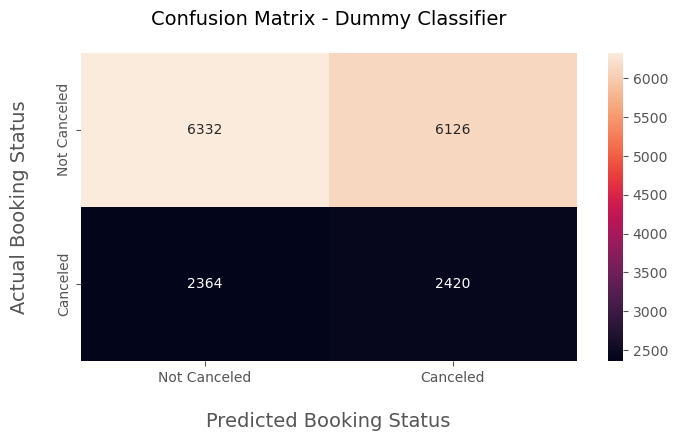

In [16]:
dummy = DummyClassifier(strategy="uniform", random_state=42)
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)


plot_results(y_test, dummy_pred, 'Dummy Classifier')

# Model 1: Logistic Regression

Precision:  0.6852141294154424
Recall:  0.45819397993311034


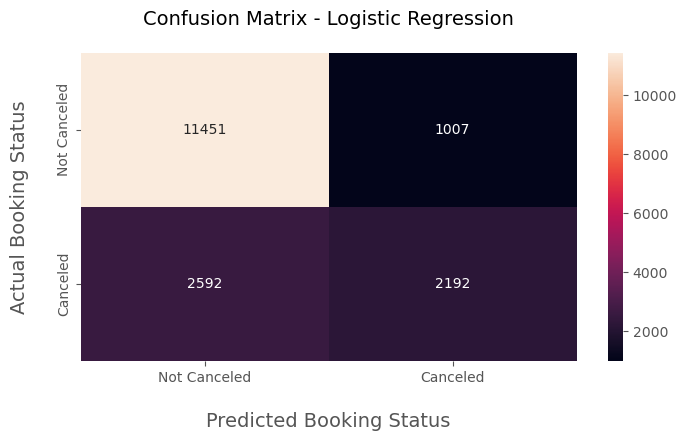

In [17]:
logreg = LogisticRegression(C=3792.690190732246, max_iter=100, penalty='l2', solver='liblinear')
logreg.fit(X_train_mm, y_train)
logreg_pred = logreg.predict(X_test_mm)

plot_results(y_test, logreg_pred, 'Logistic Regression')

In [18]:
log_odds = logreg.coef_[0]
log_odds_df = pd.DataFrame(log_odds, X_train.columns, columns=['coef']).sort_values(by='coef', ascending=False)
log_odds_df.head()

,coef
cancellation_rate,5.618846
MarketSegment_Undefined,5.402648
room_cost,3.989701
DepositType_Non Refund,3.882022
LeadTime,2.987239


In [19]:
log_odds_df.tail()

,coef
BookingChanges,-0.704599
MarketSegment_Offline TA/TO,-1.086858
special_requests,-1.132320
IsRepeatedGuest,-1.232953
RequiredCarParkingSpaces,-9.246143


In [9]:
# Hyperparameter tuning for logreg

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

#logreg_grid = GridSearchCV(logreg, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
#logreg_grid.fit(X_train_mm,y_train)

In [23]:
# Best hyperparameters
logreg_grid.best_params_

{'C': 3792.690190732246,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'liblinear'}

# Model 2: Decision Tree

Precision:  0.6921119592875318
Recall:  0.5117056856187291


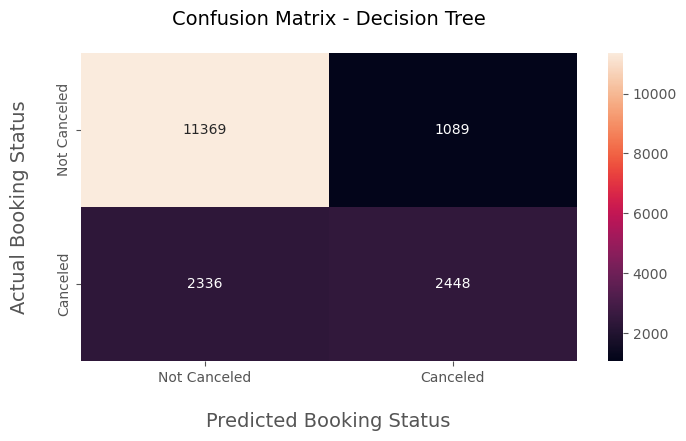

In [20]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_leaf=100, random_state=42)
dt.fit(X_train, y_train)
dt_pred= dt.predict(X_test)

plot_results(y_test, dt_pred, 'Decision Tree')

In [49]:
# Hyperparameter tuning for DT

params = {
    'max_depth': [None, 2, 3, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

#dt_grid = GridSearchCV(dt, param_grid=params, cv=5)
#dt_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 5, 10, 20],
                         'min_samples_leaf': [1, 5, 10, 20, 50, 100]})

In [59]:
dt_grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [ ]:
#tree.plot_tree(dt_grid)
#plt.show()

# Model 3: Random Forest

Precision:  0.7106288258208124
Recall:  0.5338628762541806


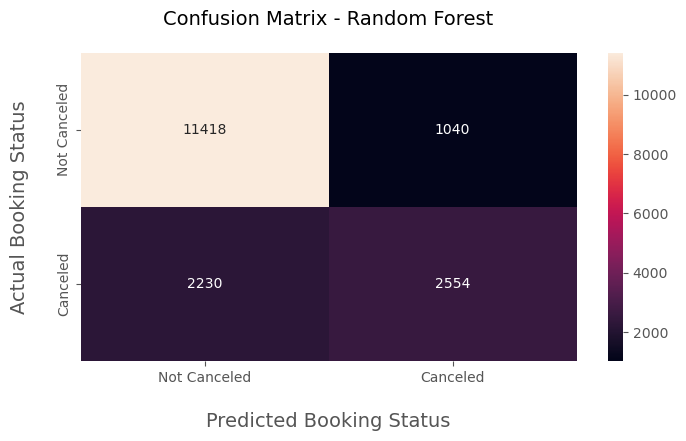

In [21]:
rf = RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5, n_estimators=400, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

plot_results(y_test, rf_pred, 'Random Forest')

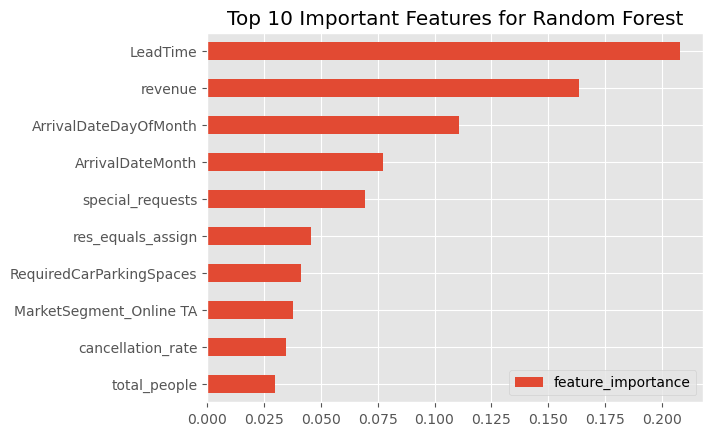

In [11]:
rf_features = pd.DataFrame(rf.feature_importances_, X_train.columns, columns=['feature_importance'])\
              .sort_values(by='feature_importance', ascending=True)

rf_features.tail(10).plot(kind='barh')
plt.title('Top 10 Important Features for Random Forest')
plt.show()

In [13]:
# Save top 20 features from rf
rf_top_feat = list(rf_features.head(20).index)

In [126]:
# Hyperparameter tuning for rf

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#rf_rand = RandomizedSearchCV(rf, param_distributions=random_grid, cv=5, n_iter=100, n_jobs=-1, random_state=42)
#rf_rand.fit(X_train, y_train)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [133]:
rf_rand.best_estimator_

RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=400, random_state=42)

# Model 4: XGboost

Precision:  0.7046962058901566
Recall:  0.5551839464882943


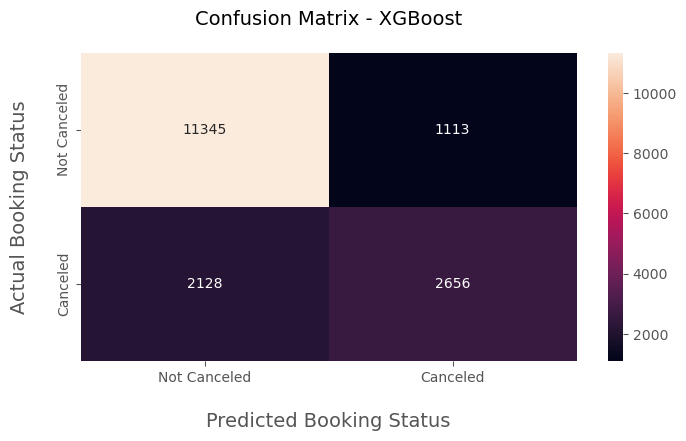

In [12]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42, n_estimators=200, max_depth=12,
                   reg_lambda = 100, reg_alpha = 0.01, learning_rate=1, gamma=1, colsample_bytree = 0.5)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)


plot_results(y_test, xgb_pred, 'XGBoost')

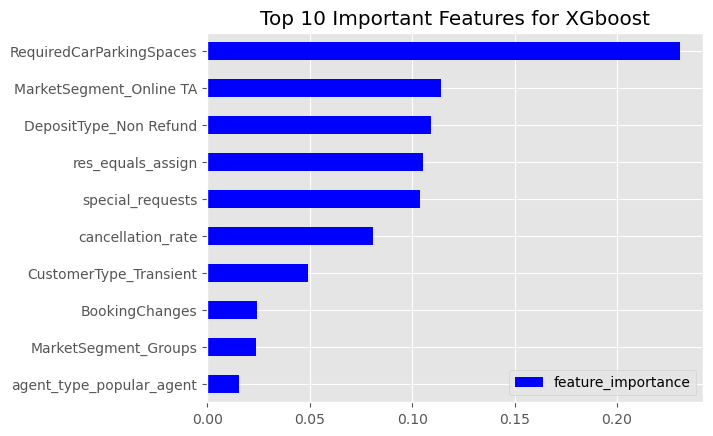

In [13]:
# Plot feature importance
xgb_features = pd.DataFrame(xgb.feature_importances_, 
             X_train.columns, 
             columns=['feature_importance'])\
            .sort_values(by='feature_importance', ascending=True)
xgb_features.tail(10).plot(kind='barh', color='blue')
plt.title('Top 10 Important Features for XGboost')
plt.show()

In [16]:
# Save top 20 features from xgb
xgb_top_feat = list(xgb_features.head(20).index)

In [17]:
# Hyperparameter tuning for xgb

# Define the search space
param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # Number of Trees in Ensemble (number of boosting rounds)
    "n_estimators" : [50, 100, 200, 300]}

#xgb_rand = RandomizedSearchCV(xgb, param_distributions=param_grid, scoring='recall' , n_iter=50, n_jobs=-1, cv=5, verbose=1)
#xgb_rand.fit(X_train, y_train)

In [23]:
xgb_rand.best_params_

{'reg_lambda': 100,
 'reg_alpha': 0.01,
 'n_estimators': 200,
 'max_depth': 12,
 'learning_rate': 1,
 'gamma': 0.0,
 'colsample_bytree': 0.5}

# Model 5: LightGBM

Precision:  0.546875
Recall:  0.7755016722408027


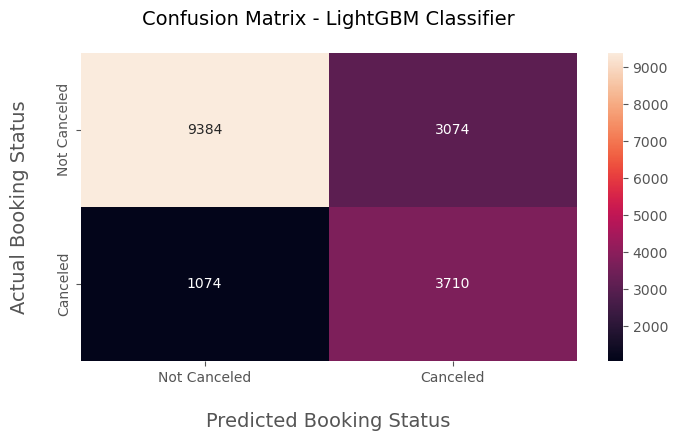

In [22]:
lgbm = LGBMClassifier(learning_rate=0.4, max_depth=5, n_estimators=100, num_leaves=10,
                     reg_alpha=0,reg_lambda=0, boosting_type='gbdt', is_unbalance=True)

lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

plot_results(y_test, lgbm_pred, 'LightGBM Classifier')

In [32]:
prob_0 = lgbm.predict_proba(X_test)[:,0]
prob_1 = lgbm.predict_proba(X_test)[:,1]

In [40]:
results_df = y_test.to_frame()
results_df['predictions'] = lgbm_pred
results_df['probability_sucessful'] = prob_0
results_df['probability_canceled'] = prob_1

mask = results_df['IsCanceled' ] != results_df['predictions']
results_df.query('IsCanceled')[mask]

,IsCanceled,predictions,probability_sucessful,probability_canceled
71651,0,1,0.438252,0.561748
5990,1,0,0.588605,0.411395
47319,1,0,0.553264,0.446736
76636,0,1,0.497490,0.502510
7481,1,0,0.691548,0.308452


In [45]:
results_df.sample(5)

,IsCanceled,predictions,probability_sucessful,probability_canceled
61522,0,1,0.412427,0.587573
43872,1,1,0.118317,0.881683
79286,0,0,0.949426,0.050574
49167,1,0,0.635925,0.364075
76885,0,0,0.701680,0.298320


In [48]:
mask2 = results_df['IsCanceled' ] == results_df['predictions']
results_df.query('probability_sucessful > 0.7 or probability_canceled > 0.7')[mask2]

,IsCanceled,predictions,probability_sucessful,probability_canceled
30732,1,1,0.162109,0.837891
57368,0,0,0.821629,0.178371
16113,0,0,0.858182,0.141818
58521,0,0,0.857362,0.142638
79026,1,1,0.197202,0.802798
...,...,...,...,...
68072,0,0,0.775418,0.224582
55496,0,0,0.928354,0.071646
64745,0,0,0.755147,0.244853
30789,0,0,0.997952,0.002048


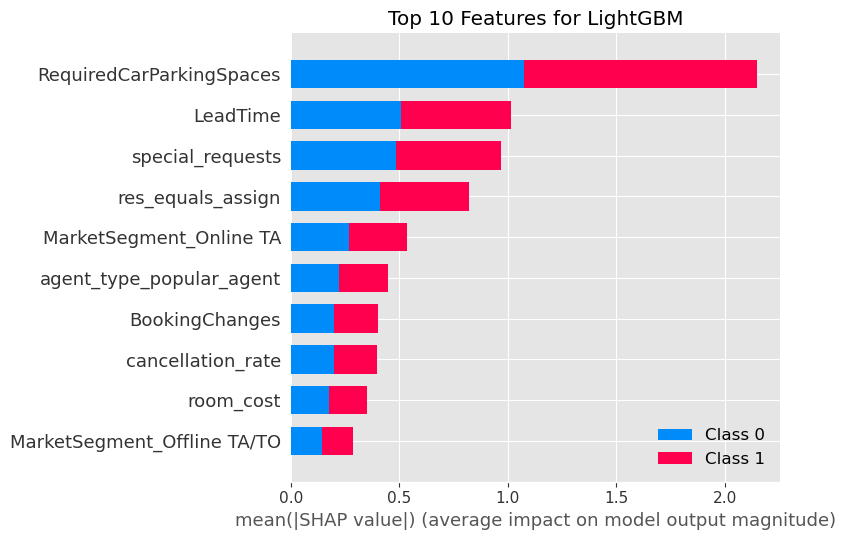

In [24]:
shap.initjs()

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train)

plt.title('Top 10 Features for LightGBM')
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, max_display=10)
plt.show()

In [26]:
params_lgb={'num_leaves':[10,20,30,40],
             'max_depth':[1,2,4,-1],
             'n_estimators':[50,100,150,200],
             'learning_rate':[0.01,0.1,0.2],
             'is_unbalance' :[True],
              'reg_alpha':[0,0.01,0.1],
              'reg_lambda':[0,0.01,0.1]
             }

lgb_rand = RandomizedSearchCV(lgbm, param_distributions=params_lgb, cv=5, scoring='f1', n_jobs=-1, n_iter = 50)
lgb_rand.fit(X_train, y_train)
lgb_rand.best_estimator_

LGBMClassifier(is_unbalance=True, learning_rate=0.2, num_leaves=40,
               reg_alpha=0.1, reg_lambda=0.1)

# Comparing Models

In [16]:
# Predict on training set to check for overfitting
dummy_train_pred = dummy.predict(X_train)
logreg_train_pred = logreg.predict(X_train_mm)
dt_train_pred = dt.predict(X_train)
rf_train_pred = rf.predict(X_train)
xgb_train_pred = xgb.predict(X_train)
lgbm_train_pred = lgbm.predict(X_train)

In [17]:
model_preds_train = [dummy_train_pred, logreg_train_pred, dt_train_pred, rf_train_pred, xgb_train_pred,lgbm_train_pred]
model_preds_test = [dummy_pred,logreg_pred, dt_pred, rf_pred, xgb_pred, lgbm_pred]


accuracy_train = []
accuracy_test = []

precision_train = []
precision_test = []

recall_train = []
recall_test = []

auc_train = []
auc_test = []

for pred in model_preds_train:
    acc = accuracy_score(y_train, pred)
    accuracy_train.append(acc)
    
    prec = precision_score(y_train, pred)
    precision_train.append(prec)
    
    rec = recall_score(y_train, pred)
    recall_train.append(rec)
    
    auc = roc_auc_score(y_train, pred)
    auc_train.append(auc)
    
for pred in model_preds_test:
    acc = accuracy_score(y_test, pred)
    accuracy_test.append(acc)
    
    prec = precision_score(y_test, pred)
    precision_test.append(prec)
    
    rec = recall_score(y_test, pred)
    recall_test.append(rec)
    
    auc = roc_auc_score(y_test, pred)
    auc_test.append(auc)

full_features_results = pd.DataFrame(index=['Dummy Classifier','Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'])
full_features_results['Train Recall'] = recall_train
full_features_results['Test Recall'] = recall_test
full_features_results['Train Precision'] = precision_train
full_features_results['Test Precision'] = precision_test
full_features_results['Train Accuracy'] = accuracy_train
full_features_results['Test Accuracy'] = accuracy_test
full_features_results['Train AUC'] = auc_train
full_features_results['Test AUC'] = auc_test

In [18]:
full_features_results.style.background_gradient(subset=['Test Recall', 'Test Precision', 'Test Accuracy','Test AUC'])

,Train Recall,Test Recall,Train Precision,Test Precision,Train Accuracy,Test Accuracy,Train AUC,Test AUC
Dummy Classifier,0.505906,0.505853,0.280166,0.283173,0.502284,0.507598,0.503399,0.507060
Logistic Regression,0.486987,0.469900,0.712603,0.704481,0.803176,0.798225,0.705786,0.697103
Decision Tree,0.525870,0.503763,0.725555,0.711754,0.813268,0.805707,0.724746,0.712710
Random Forest,0.822828,0.540761,0.950094,0.729143,0.938853,0.816843,0.903116,0.731811
XGBoost,0.655900,0.555184,0.806866,0.704696,0.860973,0.812029,0.797808,0.732922
LightGBM,0.818856,0.761915,0.603126,0.562240,0.800247,0.769342,0.805979,0.767055


In [28]:
rf_cv_recall = cross_val_score(rf, X_train, y_train, cv=5, scoring='recall', n_jobs=-1).mean()
rf_cv_recall

0.543796403002793

In [29]:
xgb_cv_recall = cross_val_score(xgb, X_train, y_train, cv=5, scoring='recall', n_jobs=-1).mean()
xgb_cv_recall

0.5730638264915789

In [22]:
lgbm_cv_recall = cross_val_score(lgbm, X_train, y_train, cv=5, scoring='recall', n_jobs=-1).mean()
lgbm_cv_recall

0.7605833779876687

# Modeling Attempts after resampling (SMOTE)

In [22]:
#from imblearn.over_sampling import SMOTE, SVMSMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [23]:
y_train_resampled.value_counts()

0    49831
1    49831
Name: IsCanceled, dtype: int64

Precision:  0.6724097238612226
Recall:  0.5955267558528428


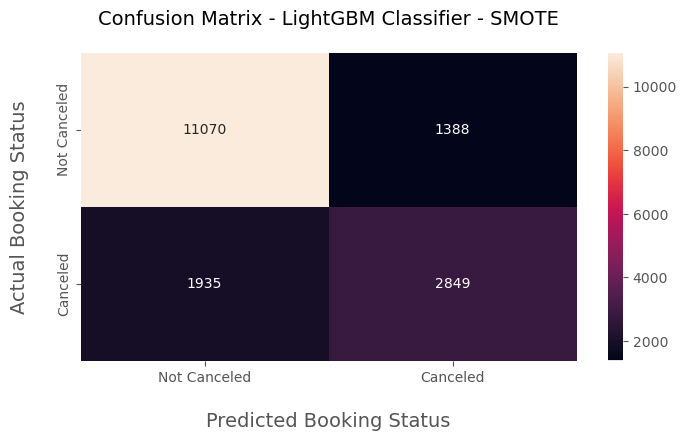

In [32]:
lgbm_smote = LGBMClassifier(learning_rate=1, max_depth=50, n_estimators=200, num_leaves=20,
                     reg_alpha=0.01,reg_lambda=0)

lgbm.fit(X_train_resampled, y_train_resampled)
lgbm_pred_smote = lgbm.predict(X_test)

plot_results(y_test, lgbm_pred_smote, 'LightGBM Classifier - SMOTE')

Precision:  0.6872184017073749
Recall:  0.6057692307692307


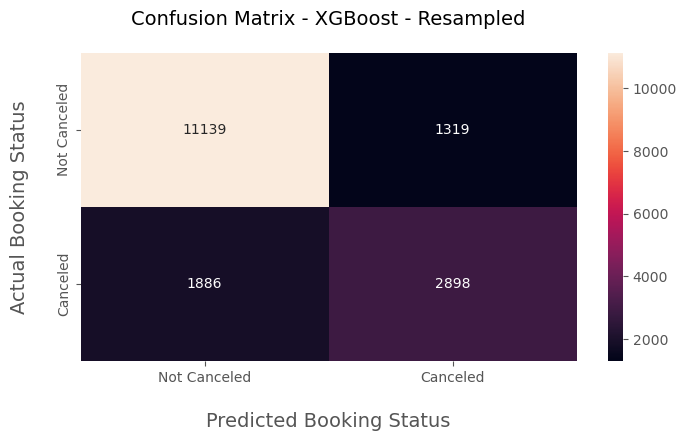

In [33]:
xgb_smote = XGBClassifier(colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=18,reg_alpha=0.01,
                          reg_lambda=1, random_state=42)
xgb_smote.fit(X_train_resampled, y_train_resampled)
xgb_smote_pred = xgb_smote.predict(X_test)

plot_results(y_test, xgb_smote_pred, 'XGBoost - Resampled')

In [67]:
# Bayesian Optimization for XGBoost

#from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])}
    
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    
# Objective function
def objective(params):
    
    xgboost = XGBClassifier(seed=0, **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_train_resampled, 
                            y=y_train_resampled, 
                            cv=kfold, 
                            scoring='recall', 
                            n_jobs=-1).mean()
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
    
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100, trials = Trials())

100%|██| 100/100 [1:35:25<00:00, 57.25s/trial, best loss: -0.8591840842332717]


In [68]:
print(best)
print(space_eval(space, best))

{'colsample_bytree': 2, 'gamma': 2, 'learning_rate': 3, 'max_depth': 5, 'reg_alpha': 1, 'reg_lambda': 3}
{'colsample_bytree': 0.5, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 18, 'reg_alpha': 0.01, 'reg_lambda': 1}


In [37]:
y_test.shape

(17242,)

# Stacking Models

Precision:  0.561443581544084
Recall:  0.7706939799331104


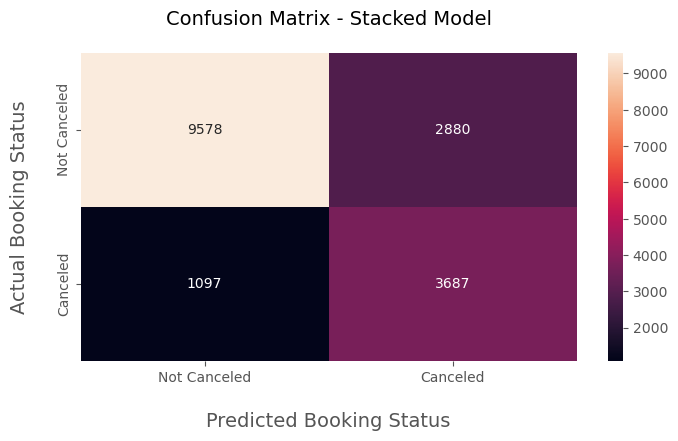

In [21]:
#from mlxtend.classifier import StackingCVClassifier

models = [xgb, lgbm]
stacking = StackingCVClassifier(classifiers=models, meta_classifier=lgbm)
stacking.fit(X_train, y_train)
stack_pred = stacking.predict(X_test)

plot_results(y_test, stack_pred, 'Stacked Model')

# Revenue Loss due to cancellations

In [54]:
df.groupby('IsCanceled')['room_cost'].sum()

IsCanceled
0    22968185.15
1    11478718.70
Name: room_cost, dtype: float64

In [55]:
loss = df.groupby('IsCanceled')['room_cost'].sum()[1]

In [59]:
total = df['room_cost'].sum()
total

34446903.85

In [58]:
(loss/total)*100

33.32293302754987

# Saving the Model

In [6]:
import pickle
pickle.dump(lgbm, open('model.pkl','wb'))

In [24]:
# testing the model
model = pickle.load(open('model.pkl','rb'))
print('Prediction: ',model.predict(X_test.sample())[0])

Prediction:  0


# Conclusions:

After trying 4 models, we found the LightGBM performed the best for the problem we are trying to solve. There are 4784 cancellations in our test set. Our model was able to correctly classify 76% (recall) of those cancellations. However, the downside of our model is there is a high number of false positives. Of the 12,458 bookings that were NOT canceled, 2979 of them were wrongly classified as cancelled. 

The goal of this project is to indentify bookings that are likely to cancel, with the hope that the hotel can target these bookings with incentives to not cancel. Of the 17,242 total bookings, the model indentifies 6448 are at risk of cancelling, 57% (precision) of which are ACTUAL cancellations. This is not neccesarily a bad thing, if they were not going to cancel anyway then the hotel won't be losing the revenue from them. What will be done with these 6448 bookings? First, the hotel (marketing?) can email the customers. If enough employees are available, they can also call the customers. Sometimes just reaching out can be enough to sway people from cancelling. Next, if they have the financial means to do so, the hotel can offer complementary meals, rooms, parking spaces, etc. There is no financial data available for this project, but if there was we could look into what this would cost the hotel and further analyze these options.